In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [2]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [3]:
file_name = "/drive/MyDrive/Colab Notebooks/lstm/passengers.csv"

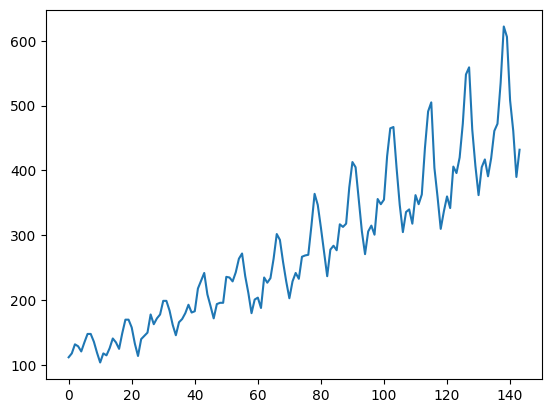

In [4]:
df = pd.read_csv(file_name)
timeseries = df[["Passengers"]].values.astype('float32')
plt.plot(timeseries)
plt.show()

In [5]:
train_size = int(len(timeseries)*0.70)
test_size = len(timeseries) - train_size
train,test = timeseries[:train_size],timeseries[train_size:]

In [18]:
def create_dataset(dataset,window_size):
  X,y = [],[]
  for i in range(len(dataset)- window_size):
    feature = dataset[i:i+window_size]
    target = dataset[i+1:i+window_size+1]
    X.append(feature)
    y.append(target)
  return torch.tensor(X),torch.tensor(y)




In [20]:
w_size = 12
X_train,y_train = create_dataset(train,w_size)
X_test, y_test = create_dataset(test,w_size)


In [21]:
print(X_train.shape)
print(y_train.shape)

torch.Size([88, 12, 1])
torch.Size([88, 12, 1])


In [22]:
class MyModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.lstm = nn.LSTM(input_size=1,hidden_size=75,num_layers=1,batch_first=True)
    self.linear=nn.Linear(75,1)
  
  def forward(self,x):
    x, _ = self.lstm(x)
    x = self.linear(x)
    return x





In [23]:
model = MyModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train,y_train),shuffle=True,batch_size=12)

n_epoches = 5000
for epoch in range(n_epoches):
  model.train()
  for X_batch,y_batch in loader:
    y_pred = model(X_batch)
    loss = loss_fn(y_pred,y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  if(epoch % 100 != 0):
    continue
  model.eval()
  with torch.no_grad():
    y_pred = model(X_train)
    train_rmse = np.sqrt(loss_fn(y_pred,y_train))
    y_pred = model(X_test)
    test_rmse = np.sqrt(loss_fn(y_pred,y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))








Epoch 0: train RMSE 228.1922, test RMSE 422.6585
Epoch 100: train RMSE 177.2447, test RMSE 369.4318
Epoch 200: train RMSE 139.0058, test RMSE 327.8784
Epoch 300: train RMSE 108.7290, test RMSE 292.3518
Epoch 400: train RMSE 87.0777, test RMSE 262.7856
Epoch 500: train RMSE 65.4953, test RMSE 231.6200
Epoch 600: train RMSE 51.5345, test RMSE 206.2370
Epoch 700: train RMSE 41.0160, test RMSE 184.3338
Epoch 800: train RMSE 33.8275, test RMSE 166.0262
Epoch 900: train RMSE 28.4993, test RMSE 150.0199
Epoch 1000: train RMSE 23.9992, test RMSE 135.7553
Epoch 1100: train RMSE 20.8989, test RMSE 123.4656
Epoch 1200: train RMSE 18.5874, test RMSE 113.0043
Epoch 1300: train RMSE 16.9757, test RMSE 104.3852
Epoch 1400: train RMSE 15.2648, test RMSE 96.3317
Epoch 1500: train RMSE 14.4158, test RMSE 90.9859
Epoch 1600: train RMSE 13.5927, test RMSE 86.5815
Epoch 1700: train RMSE 13.4182, test RMSE 82.8191
Epoch 1800: train RMSE 12.1719, test RMSE 80.1959
Epoch 1900: train RMSE 12.0977, test RMSE 79

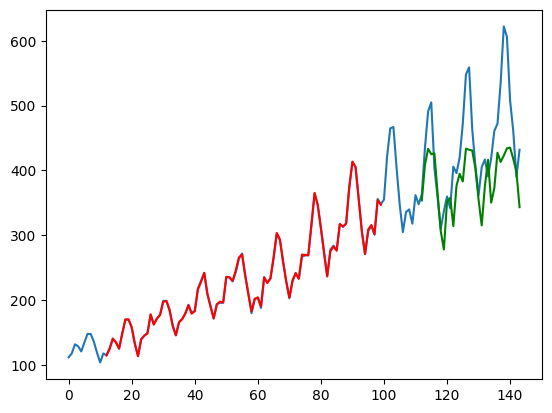

In [24]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[w_size:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+w_size:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()